# Generative Models as Data Augmentation in the Medical Domain

## 1. Overview

This project tries to evaluate the quality of generative models for data augmentation in the medical domain. 

Data augmentation will be relying on geometric data augmentation, (variational) auto-encoder (e.g. stacked denoising, denoising auto-encoder, etc.), and generative adversarial neural networks (e.g. GAN, DCGAN, Wasserstein GAN, etc.) for instance.

We will restrict ourself to three kind of models to generate new data and evaluate the (possible) improvement with regards to a final classification score (i.e. comparing results between augmented and non-augmented training sets). 

### Datasets

We will look into applying the above project on some (if not all) of the following datasets from the MedMNIST Classification Decathlon (https://medmnist.github.io/):

| Dataset | Classification Type | Train size | Validation size | Test size |
| :--- | :--- | :---: | :---: | :---: |  
| PathMNIST Pathology | Multi-Class (9) | 89,996 | 10,004 | 7,180 |
| DermaMNIST Dermatoscope | Multi-Class (7) | 7,007 | 1,003 | 2,005 |
| OCTMNIST OCT | Multi-Class (4) | 97,477 | 10,832 | 1,000 |
| PneumoniaMNIST Chest X-ray | Binary-Class (2) |4,708 | 524 | 624 |
| BreastMNIST Breast Ultrasound | Binary-Class (2) | 546 | 78 | 156 |
| OrganMNIST_Axial Abdominal CT | Multi-Class (11) | 34,581 | 6,491 | 17,778 |
| OragnMNIST_Coronal Abdominal CT | Multi-Class (11) |13,000 | 2,392 | 8,268 |
| OrganMNIST_Sagittal Abdominal CT | Multi-Class (11) | 13,940 | 2,452 | 8,829 |

### Notes

We will also provide a short report (in copy) explaining the choice of VAE, AE, and/or GAN models, outlining differences between datasets' results. We will also try to interprete and justify possible differences with regards to models, data specifications, visual features, and bibliography references used to support the choices made.

## 2. Data and Library Imports

### Source

We will retrieve the above dataset from the following website:

> [MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification](https://medmnist.com/), Jiancheng Yang,Rui Shi,Donglai Wei,Zequan Liu,Lin Zhao,Bilian Ke,Hanspeter Pfister,Bingbing Ni

By following the instructions on their [github](https://github.com/MedMNIST/MedMNIST), we can download their ready-made module with the following instruction:

```sh
pip install jupyter, ipywidgets, IProgress
pip install medmnist
```

And load it in a python or ipython instance:

```python
import medmnist
```

### Library Imports

In [1]:
from python_scripts.classifier import run_classifier_pipeline
from python_scripts.variational_autoencoders import run_encoder_pipeline, one_hot
from python_scripts.data import retrieve_flag_info, import_dataset
from python_scripts.data import check_cuda_availability
from python_scripts.data import generate_augmented_dataset_condVAE
# from python_scripts.data import generate_augmented_dataset_jointVAE

import warnings
warnings.filterwarnings('ignore')

### Checks CUDA availability

In [2]:
check_cuda_availability()

True,0,<torch.cuda.device object at 0x7fca08646cd0>,1
NVIDIA GeForce GTX 980 Ti


### Data Imports

In [3]:
data_flags = ["pathmnist", "dermamnist", "octmnist", "pneumoniamnist", 
              "breastmnist", "organamnist", "organcmnist", "organsmnist"]

info_flags = {flag:retrieve_flag_info(flag) for flag in data_flags}

Using downloaded and verified file: /home/quentin/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/pathmnist.npz
Montage of randomly extracted images from the dataset:


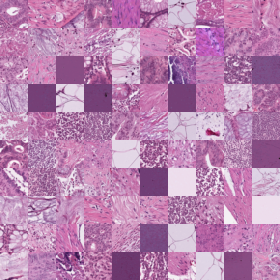

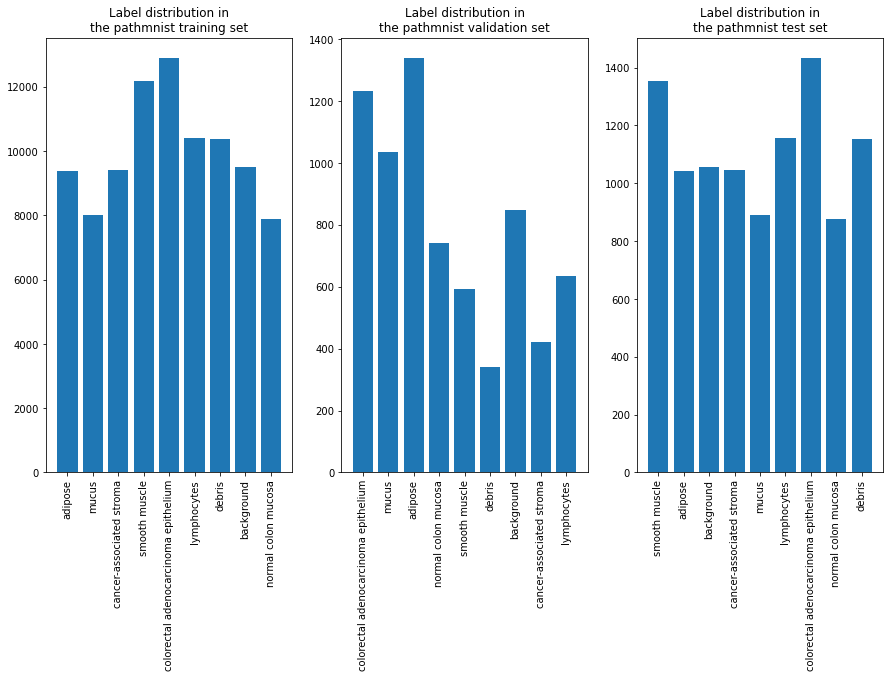

In [4]:
pathmnist = import_dataset("pathmnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Montage of randomly extracted images from the dataset:


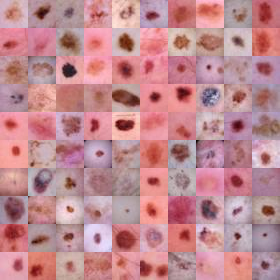

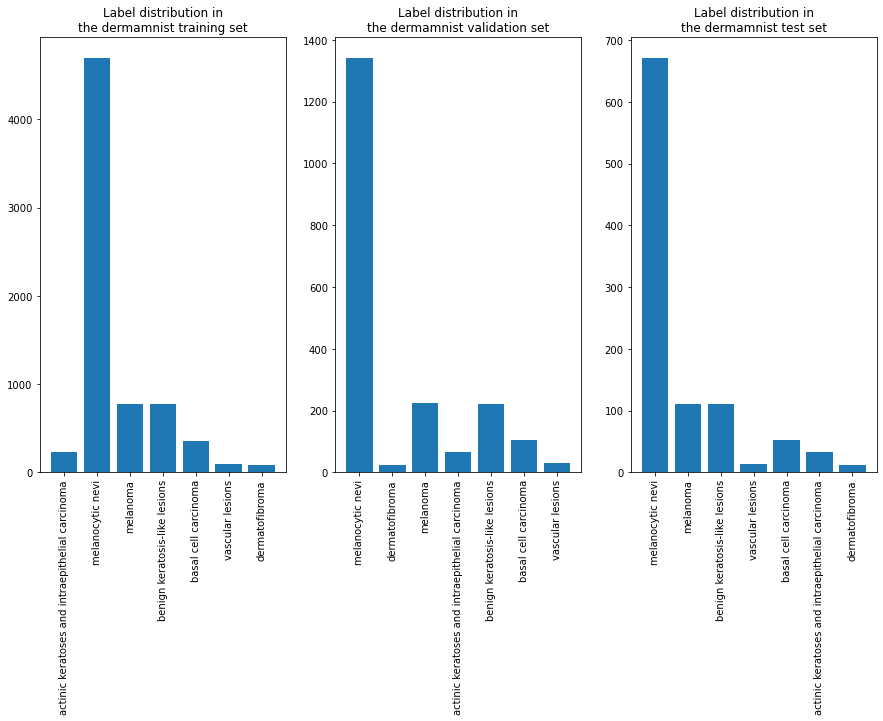

In [10]:
dermamnist = import_dataset("dermamnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/octmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/octmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/octmnist.npz
Montage of randomly extracted images from the dataset:


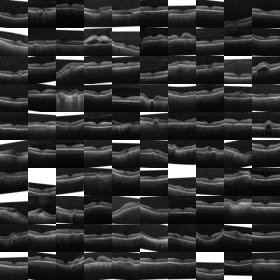

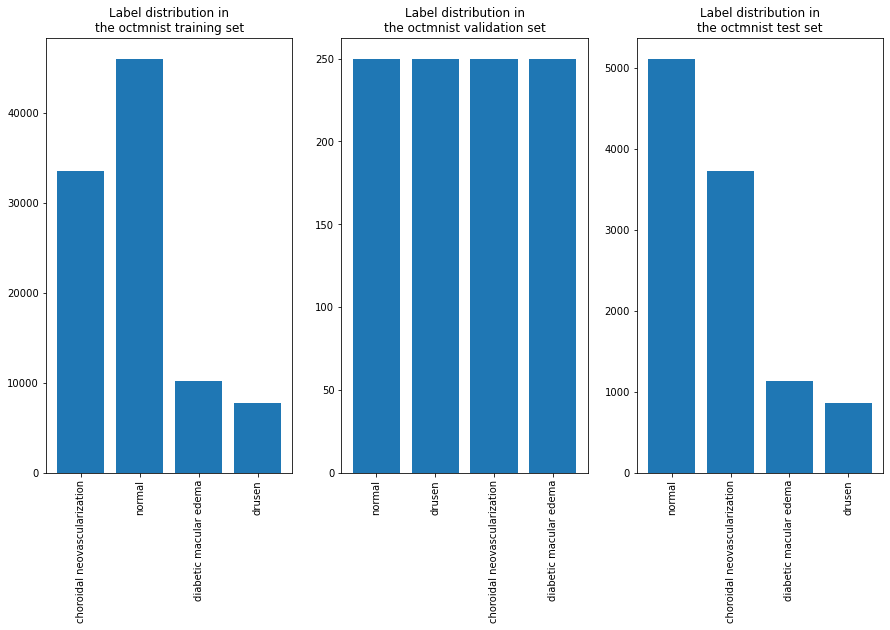

In [11]:
octmnist = import_dataset("octmnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/pneumoniamnist.npz
Montage of randomly extracted images from the dataset:


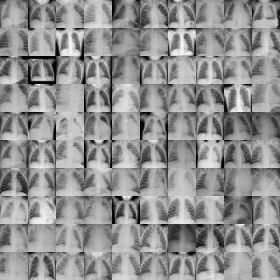

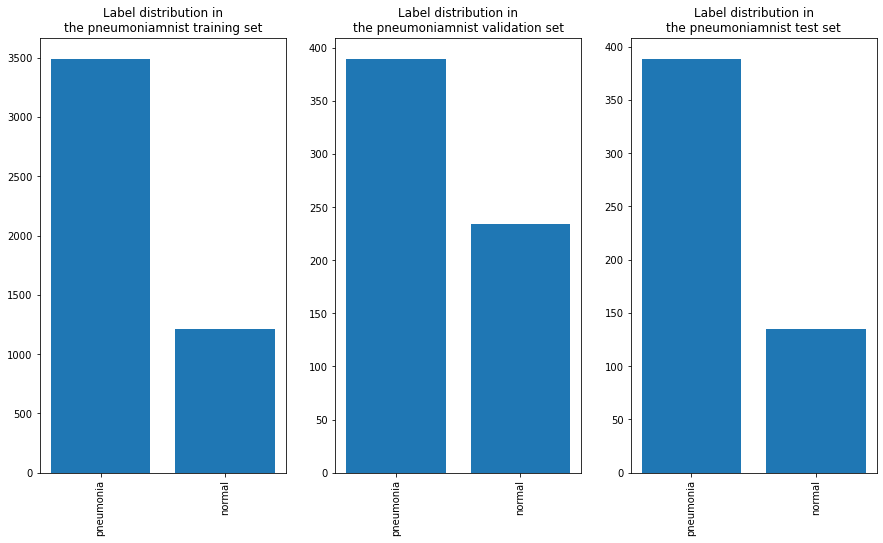

In [12]:
pneumoniamnist = import_dataset("pneumoniamnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/breastmnist.npz
Montage of randomly extracted images from the dataset:


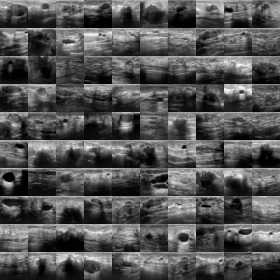

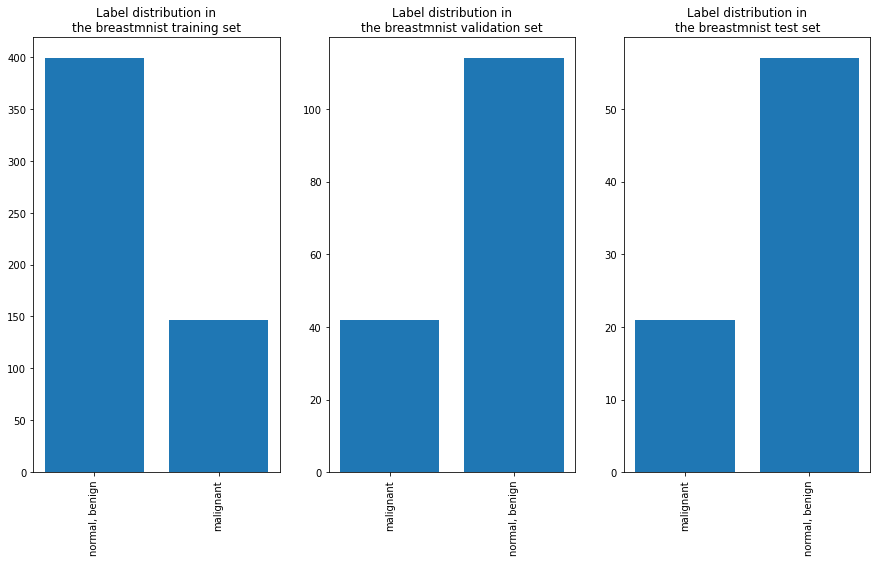

In [13]:
breastmnist = import_dataset("breastmnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/organamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/organamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/organamnist.npz
Montage of randomly extracted images from the dataset:


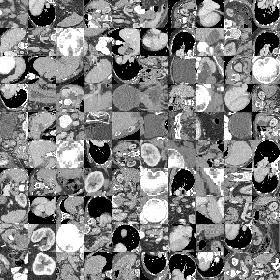

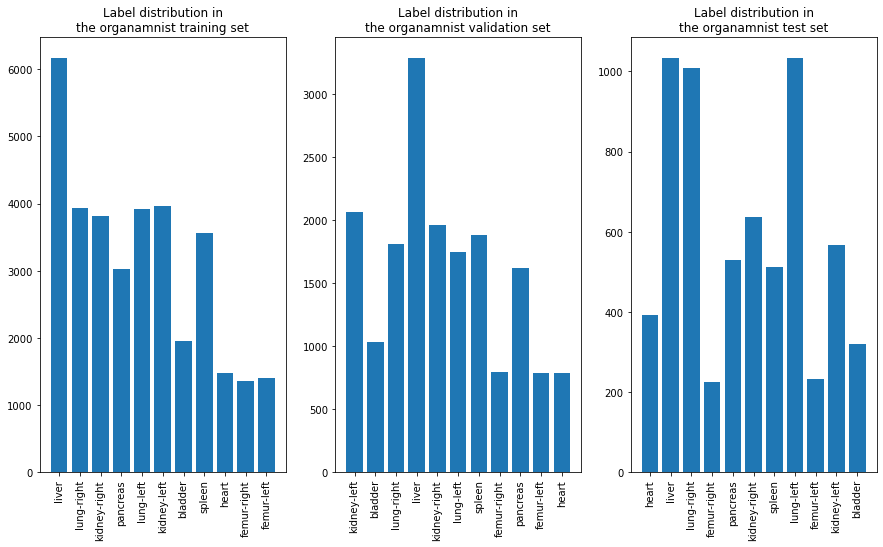

In [14]:
organamnist = import_dataset("organamnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/organcmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/organcmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/organcmnist.npz
Montage of randomly extracted images from the dataset:


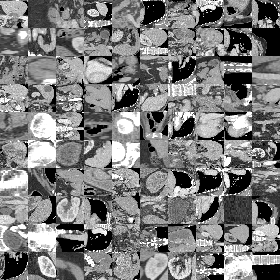

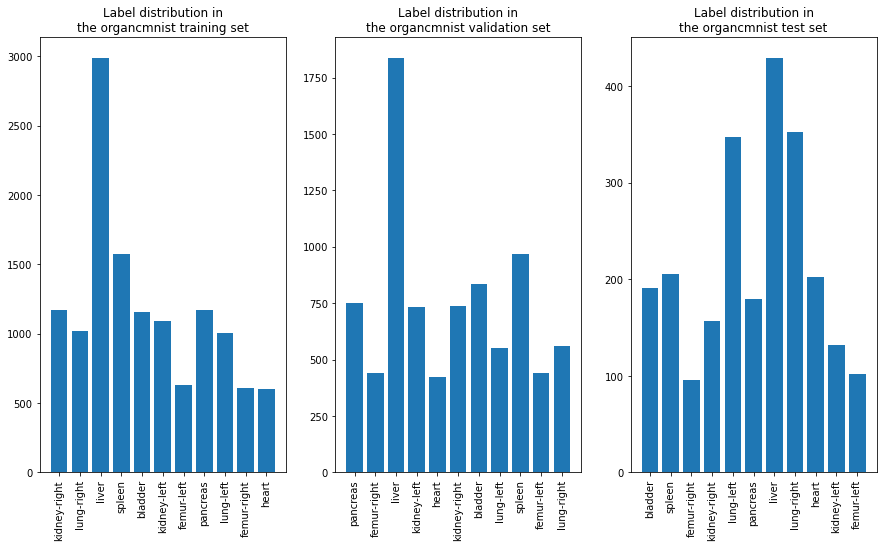

In [15]:
organcmnist = import_dataset("organcmnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/organsmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/organsmnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/organsmnist.npz
Montage of randomly extracted images from the dataset:


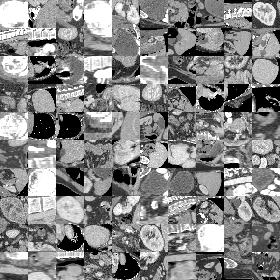

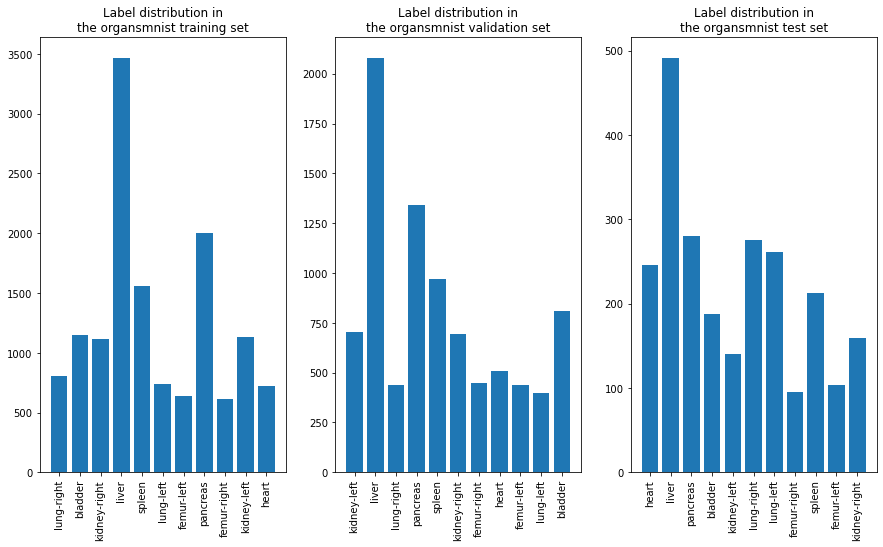

In [16]:
organsmnist = import_dataset("organsmnist", info_flags)

## 3. Training a Classifier Without Data Augmentation

### PathMNIST

{
  "python_class": "PathMNIST",
  "description": "The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3\u00d7224\u00d7224 into 3\u00d728\u00d728, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/pathmnist.npz?download=1",
  "MD5": "a8b06965200029087d5bd730944a56c1",
  "task": "multi-class",
  "label": {
    "0": "adipose",
    "1": "background",
    "2": "debris",
    "3": "lymphocytes",
    "4": "mucus",
    "5": "smooth muscle",
    "6": "normal colon mucosa"

100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 33.67it/s]


train -- accuracy: 0.72
val -- accuracy: 0.98,  AUC: 0.78
Epoch 1



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.07it/s]


train -- accuracy: 0.86
val -- accuracy: 0.98,  AUC: 0.82
Epoch 2



100%|█████████████████████████████████████████| 704/704 [00:21<00:00, 33.48it/s]


train -- accuracy: 0.9
val -- accuracy: 0.99,  AUC: 0.83
Epoch 3



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.81it/s]


train -- accuracy: 0.92
val -- accuracy: 0.99,  AUC: 0.8
Epoch 4



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.86it/s]


train -- accuracy: 0.92
val -- accuracy: 1.0,  AUC: 0.91
Epoch 5



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.60it/s]


train -- accuracy: 0.94
val -- accuracy: 0.99,  AUC: 0.83
Epoch 6



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.59it/s]


train -- accuracy: 0.94
val -- accuracy: 0.99,  AUC: 0.9
Epoch 7



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.49it/s]


train -- accuracy: 0.95
val -- accuracy: 1.0,  AUC: 0.93
Epoch 8



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.85it/s]


train -- accuracy: 0.95
val -- accuracy: 1.0,  AUC: 0.92
Epoch 9



100%|█████████████████████████████████████████| 704/704 [00:20<00:00, 34.45it/s]


train -- accuracy: 0.96
val -- accuracy: 1.0,  AUC: 0.93
test -- accuracy: 0.98,  AUC: 0.85


<Figure size 720x720 with 0 Axes>

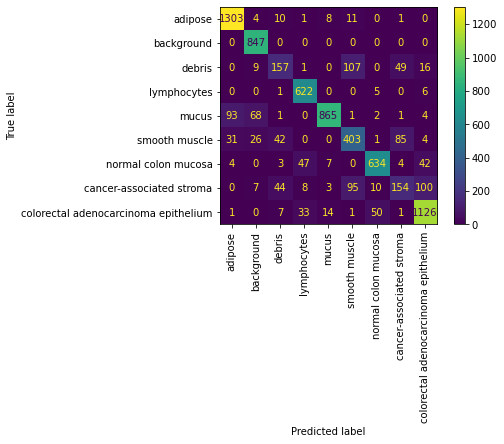

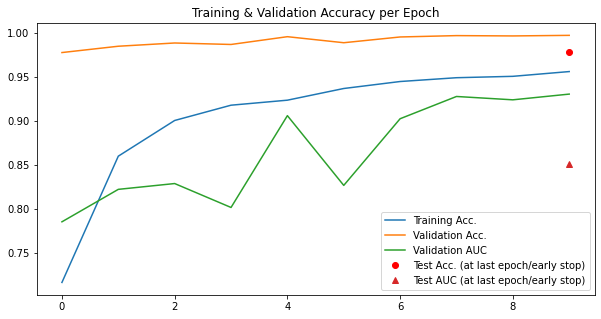

In [12]:
clf_base_pathmnist = run_classifier_pipeline("pathmnist", info_flags, pathmnist)

### DermaMNIST

{
  "python_class": "DermaMNIST",
  "description": "The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3\u00d7600\u00d7450 are resized into 3\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/dermamnist.npz?download=1",
  "MD5": "0744692d530f8e62ec473284d019b0c7",
  "task": "multi-class",
  "label": {
    "0": "actinic keratoses and intraepithelial carcinoma",
    "1": "basal cell carcinoma",
    "2": "benign keratosis-like lesions",
    "3": "dermatofibroma",
    "4": "melanoma",
    "5": "melanocytic nevi",
    "6": "vascular lesions"
  },
  "n_channels": 3,
  "n_samples": {
    "train": 7007,
    "val": 1003,
    "test": 2005
  },
  "license": "CC B

100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 33.60it/s]


train -- accuracy: 0.31
val -- accuracy: 0.85,  AUC: 0.44
Epoch 1



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 32.78it/s]


train -- accuracy: 0.53
val -- accuracy: 0.89,  AUC: 0.58
Epoch 2



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 34.19it/s]


train -- accuracy: 0.64
val -- accuracy: 0.85,  AUC: 0.33
Epoch 3



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 34.63it/s]


train -- accuracy: 0.71
val -- accuracy: 0.86,  AUC: 0.51
Epoch 4



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 35.89it/s]


train -- accuracy: 0.77
val -- accuracy: 0.89,  AUC: 0.56
Epoch 5



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 34.48it/s]


train -- accuracy: 0.82
val -- accuracy: 0.9,  AUC: 0.63
Epoch 6



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 33.35it/s]


train -- accuracy: 0.85
val -- accuracy: 0.88,  AUC: 0.57
Epoch 7



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 34.14it/s]


train -- accuracy: 0.87
val -- accuracy: 0.89,  AUC: 0.61
Epoch 8



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 32.90it/s]


train -- accuracy: 0.88
val -- accuracy: 0.88,  AUC: 0.58
Epoch 9



100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 34.87it/s]


train -- accuracy: 0.91
val -- accuracy: 0.9,  AUC: 0.67
test -- accuracy: 0.89,  AUC: 0.68


<Figure size 720x720 with 0 Axes>

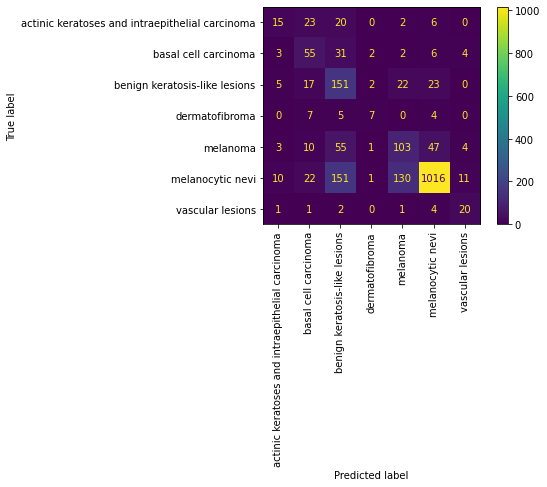

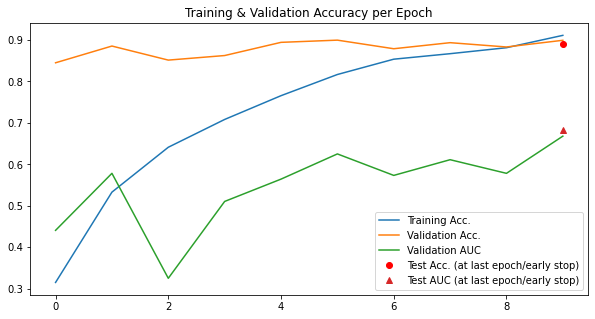

In [13]:
clf_base_dermamnist = run_classifier_pipeline("dermamnist", info_flags, dermamnist)

### OctMNIST

{
  "python_class": "OCTMNIST",
  "description": "The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384\u22121,536)\u00d7(277\u2212512). We center-crop the images and resize them into 1\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/octmnist.npz?download=1",
  "MD5": "c68d92d5b585d8d81f7112f81e2d0842",
  "task": "multi-class",
  "label": {
    "0": "choroidal neovascularization",
    "1": "diabetic macular edema",
    "2": "drusen",
    "3": "normal"
  },
  "n_channels": 1,
  "n_samples": {
    "train": 97477,
    "val": 10832,
    "test": 1000
  },
  "license": "CC BY 4.0"
}
Epoch 0



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 39.26it/s]


train -- accuracy: 0.73
val -- accuracy: 0.95,  AUC: 0.77
Epoch 1



100%|█████████████████████████████████████████| 762/762 [00:20<00:00, 37.86it/s]


train -- accuracy: 0.83
val -- accuracy: 0.96,  AUC: 0.82
Epoch 2



100%|█████████████████████████████████████████| 762/762 [00:20<00:00, 37.79it/s]


train -- accuracy: 0.86
val -- accuracy: 0.97,  AUC: 0.88
Epoch 3



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 39.64it/s]


train -- accuracy: 0.88
val -- accuracy: 0.97,  AUC: 0.87
Epoch 4



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 38.15it/s]


train -- accuracy: 0.9
val -- accuracy: 0.97,  AUC: 0.86
Epoch 5



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 39.82it/s]


train -- accuracy: 0.91
val -- accuracy: 0.97,  AUC: 0.86
Epoch 6



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 39.30it/s]


train -- accuracy: 0.92
val -- accuracy: 0.97,  AUC: 0.9
Epoch 7



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 38.27it/s]


train -- accuracy: 0.93
val -- accuracy: 0.97,  AUC: 0.87
Epoch 8



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 39.97it/s]


train -- accuracy: 0.94
val -- accuracy: 0.97,  AUC: 0.84
Epoch 9



100%|█████████████████████████████████████████| 762/762 [00:19<00:00, 39.42it/s]


train -- accuracy: 0.95
val -- accuracy: 0.97,  AUC: 0.86
test -- accuracy: 0.93,  AUC: 0.7


<Figure size 720x720 with 0 Axes>

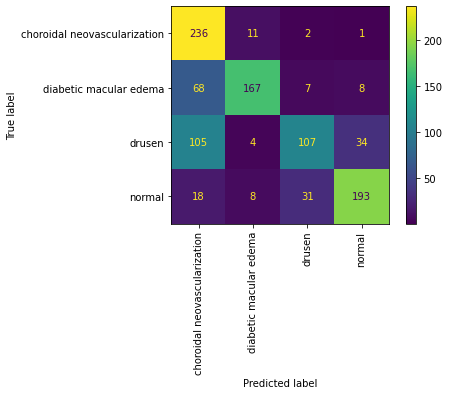

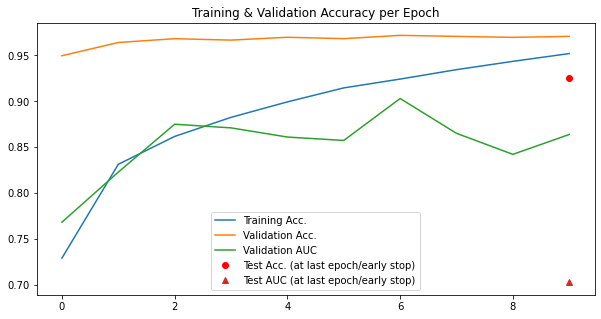

In [14]:
clf_base_octmnist = run_classifier_pipeline("octmnist", info_flags, octmnist)

### PneumoniaMNIST

{
  "python_class": "PneumoniaMNIST",
  "description": "The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384\u22122,916)\u00d7(127\u22122,713). We center-crop the images and resize them into 1\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/pneumoniamnist.npz?download=1",
  "MD5": "28209eda62fecd6e6a2d98b1501bb15f",
  "task": "binary-class",
  "label": {
    "0": "normal",
    "1": "pneumonia"
  },
  "n_channels": 1,
  "n_samples": {
    "train": 4708,
    "val": 524,
    "test": 624
  },
  "license": "CC BY 4.0"
}
Epoch 0



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 37.63it/s]


train -- accuracy: 0.8
val -- accuracy: 0.93,  AUC: 0.74
Epoch 1



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 39.97it/s]


train -- accuracy: 0.95
val -- accuracy: 0.99,  AUC: 0.93
Epoch 2



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 39.16it/s]


train -- accuracy: 0.97
val -- accuracy: 1.0,  AUC: 0.97
Epoch 3



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 40.27it/s]


train -- accuracy: 0.98
val -- accuracy: 1.0,  AUC: 0.91
Epoch 4



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 40.05it/s]


train -- accuracy: 0.98
val -- accuracy: 0.99,  AUC: 0.96
Epoch 5



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 40.52it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
Epoch 6



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 40.26it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.98
Epoch 7



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 40.49it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
Epoch 8



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 39.54it/s]


train -- accuracy: 1.0
val -- accuracy: 1.0,  AUC: 0.97
Epoch 9



100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 39.81it/s]


train -- accuracy: 0.99
val -- accuracy: 0.99,  AUC: 0.97
test -- accuracy: 0.95,  AUC: 0.85


<Figure size 720x720 with 0 Axes>

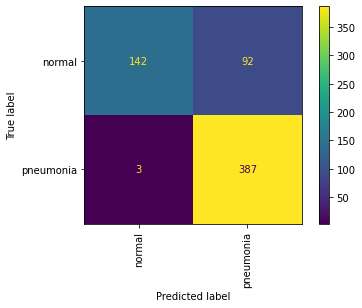

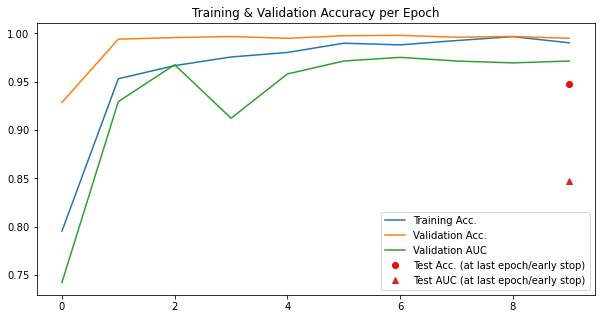

In [15]:
clf_base_pneumoniamnist = run_classifier_pipeline("pneumoniamnist", info_flags, pneumoniamnist)

### BreastMNIST

{
  "python_class": "BreastMNIST",
  "description": "The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1\u00d7500\u00d7500 are resized into 1\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/breastmnist.npz?download=1",
  "MD5": "750601b1f35ba3300ea97c75c52ff8f6",
  "task": "binary-class",
  "label": {
    "0": "malignant",
    "1": "normal, benign"
  },
  "n_channels": 1,
  "n_samples": {
    "train": 546,
    "val": 78,
    "test": 156
  },
  "license": "CC BY 4.0"
}
Epoch 0



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.83it/s]


train -- accuracy: 0.52
val -- accuracy: 0.58,  AUC: 0.27
Epoch 1



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.10it/s]


train -- accuracy: 0.68
val -- accuracy: 0.63,  AUC: 0.27
Epoch 2



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.32it/s]


train -- accuracy: 0.75
val -- accuracy: 0.67,  AUC: 0.27
Epoch 3



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.98it/s]


train -- accuracy: 0.76
val -- accuracy: 0.7,  AUC: 0.27
Epoch 4



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 45.13it/s]


train -- accuracy: 0.78
val -- accuracy: 0.7,  AUC: 0.27
Epoch 5



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.66it/s]


train -- accuracy: 0.76
val -- accuracy: 0.77,  AUC: 0.27
Epoch 6



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.97it/s]


train -- accuracy: 0.86
val -- accuracy: 0.81,  AUC: 0.31
Epoch 7



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 43.71it/s]


train -- accuracy: 0.82
val -- accuracy: 0.88,  AUC: 0.38
Epoch 8



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 41.51it/s]


train -- accuracy: 0.91
val -- accuracy: 0.9,  AUC: 0.58
Epoch 9



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 42.63it/s]


train -- accuracy: 0.93
val -- accuracy: 0.9,  AUC: 0.72
test -- accuracy: 0.86,  AUC: 0.72


<Figure size 720x720 with 0 Axes>

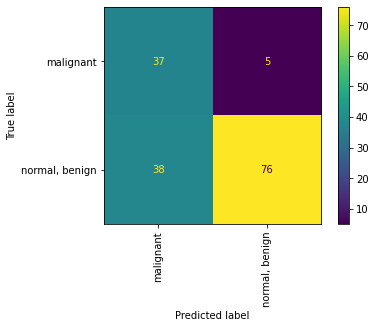

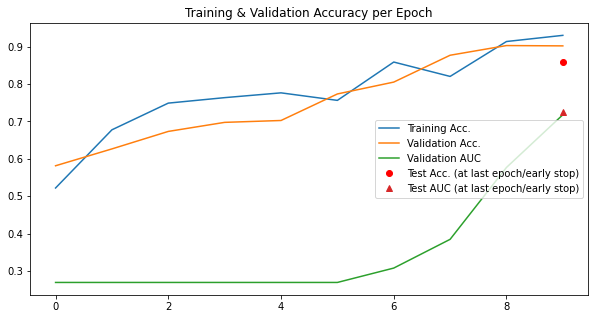

In [16]:
clf_base_breastmnist = run_classifier_pipeline("breastmnist", info_flags, breastmnist)

### OrganAMNIST

{
  "python_class": "OrganAMNIST",
  "description": "The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1\u00d728\u00d728 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/organamnist.npz?download=1",
  "MD5": "866b832ed4eeba67bfb9edee1d5544e6",
  "task": "multi-class",
  "label": {
    "0": "bladder",
    "1": "femur-left",

100%|█████████████████████████████████████████| 271/271 [00:07<00:00, 37.99it/s]


train -- accuracy: 0.71
val -- accuracy: 1.0,  AUC: 0.92
Epoch 1



100%|█████████████████████████████████████████| 271/271 [00:07<00:00, 37.58it/s]


train -- accuracy: 0.94
val -- accuracy: 1.0,  AUC: 0.96
Epoch 2



100%|█████████████████████████████████████████| 271/271 [00:06<00:00, 39.88it/s]


train -- accuracy: 0.96
val -- accuracy: 1.0,  AUC: 0.96
Epoch 3



100%|█████████████████████████████████████████| 271/271 [00:06<00:00, 39.39it/s]


train -- accuracy: 0.98
val -- accuracy: 1.0,  AUC: 0.95
Epoch 4



100%|█████████████████████████████████████████| 271/271 [00:07<00:00, 38.60it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
Epoch 5



100%|█████████████████████████████████████████| 271/271 [00:06<00:00, 39.07it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.96
Epoch 6



100%|█████████████████████████████████████████| 271/271 [00:07<00:00, 37.85it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.96
Epoch 7



100%|█████████████████████████████████████████| 271/271 [00:07<00:00, 37.84it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
Epoch 8



100%|█████████████████████████████████████████| 271/271 [00:07<00:00, 38.64it/s]


train -- accuracy: 1.0
val -- accuracy: 1.0,  AUC: 0.97
Epoch 9



100%|█████████████████████████████████████████| 271/271 [00:06<00:00, 40.05it/s]


train -- accuracy: 1.0
val -- accuracy: 1.0,  AUC: 0.96
test -- accuracy: 0.99,  AUC: 0.89


<Figure size 720x720 with 0 Axes>

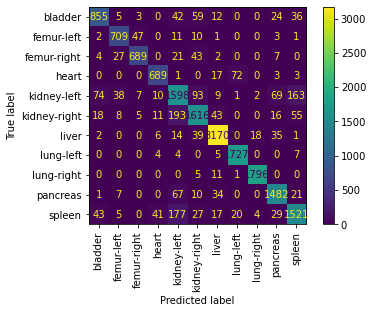

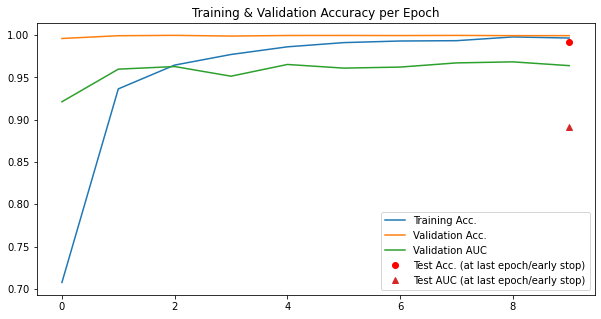

In [17]:
clf_base_organamnist = run_classifier_pipeline("organamnist", info_flags, organamnist)

### OrganCMNIST

{
  "python_class": "OrganCMNIST",
  "description": "The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1\u00d728\u00d728 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/organcmnist.npz?download=1",
  "MD5": "0afa5834fb105f7705a7d93372119a21",
  "task": "multi-class",
  "label": {
    "0": "bladder",
    "1": "femur-le

100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 40.33it/s]


train -- accuracy: 0.48
val -- accuracy: 0.98,  AUC: 0.78
Epoch 1



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 39.40it/s]


train -- accuracy: 0.8
val -- accuracy: 1.0,  AUC: 0.93
Epoch 2



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 37.17it/s]


train -- accuracy: 0.88
val -- accuracy: 1.0,  AUC: 0.93
Epoch 3



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 38.10it/s]


train -- accuracy: 0.92
val -- accuracy: 1.0,  AUC: 0.95
Epoch 4



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 38.14it/s]


train -- accuracy: 0.93
val -- accuracy: 1.0,  AUC: 0.95
Epoch 5



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 40.61it/s]


train -- accuracy: 0.95
val -- accuracy: 1.0,  AUC: 0.92
Epoch 6



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 40.34it/s]


train -- accuracy: 0.96
val -- accuracy: 1.0,  AUC: 0.95
Epoch 7



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 38.00it/s]


train -- accuracy: 0.96
val -- accuracy: 1.0,  AUC: 0.95
Epoch 8



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 38.82it/s]


train -- accuracy: 0.97
val -- accuracy: 1.0,  AUC: 0.95
Epoch 9



100%|█████████████████████████████████████████| 102/102 [00:02<00:00, 40.21it/s]


train -- accuracy: 0.97
val -- accuracy: 1.0,  AUC: 0.96
test -- accuracy: 0.99,  AUC: 0.86


<Figure size 720x720 with 0 Axes>

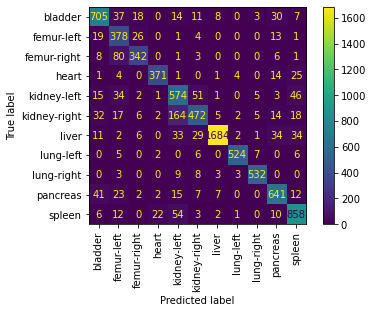

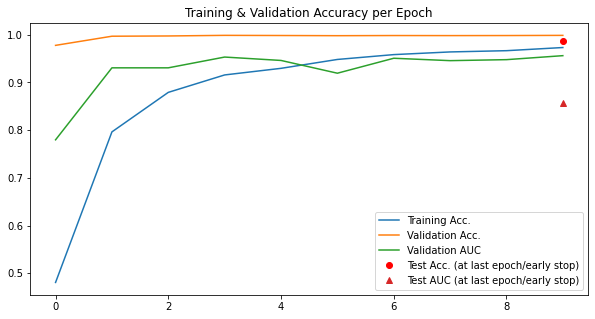

In [18]:
clf_base_organcmnist = run_classifier_pipeline("organcmnist", info_flags, organcmnist)

### OrganSMNIST

{
  "python_class": "OrganSMNIST",
  "description": "The OrganSMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Sagittal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in sagittal views (planes). The images are resized into 1\u00d728\u00d728 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/organsmnist.npz?download=1",
  "MD5": "e5c39f1af030238290b9557d9503af9d",
  "task": "multi-class",
  "label": {
    "0": "bladder",
    "1": "femur-

100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.11it/s]


train -- accuracy: 0.37
val -- accuracy: 0.96,  AUC: 0.67
Epoch 1



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.32it/s]


train -- accuracy: 0.65
val -- accuracy: 0.98,  AUC: 0.76
Epoch 2



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.29it/s]


train -- accuracy: 0.73
val -- accuracy: 0.98,  AUC: 0.73
Epoch 3



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.14it/s]


train -- accuracy: 0.77
val -- accuracy: 0.99,  AUC: 0.83
Epoch 4



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.37it/s]


train -- accuracy: 0.81
val -- accuracy: 0.99,  AUC: 0.83
Epoch 5



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.23it/s]


train -- accuracy: 0.84
val -- accuracy: 0.99,  AUC: 0.84
Epoch 6



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 39.45it/s]


train -- accuracy: 0.84
val -- accuracy: 0.99,  AUC: 0.82
Epoch 7



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.48it/s]


train -- accuracy: 0.87
val -- accuracy: 0.99,  AUC: 0.84
Epoch 8



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.21it/s]


train -- accuracy: 0.9
val -- accuracy: 0.99,  AUC: 0.83
Epoch 9



100%|█████████████████████████████████████████| 109/109 [00:02<00:00, 40.06it/s]


train -- accuracy: 0.91
val -- accuracy: 0.99,  AUC: 0.85
test -- accuracy: 0.96,  AUC: 0.72


<Figure size 720x720 with 0 Axes>

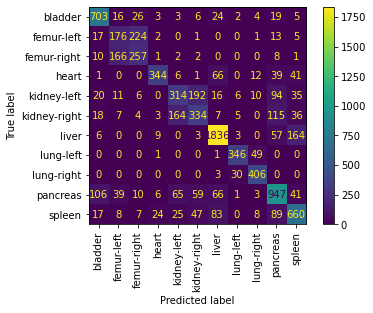

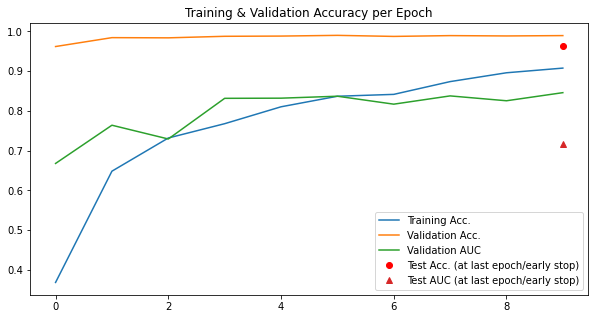

In [19]:
clf_base_organsmnist = run_classifier_pipeline("organsmnist", info_flags, organsmnist)

## 4. Training a Conditional Variational Autoencoder for Data Augmentation and Retraining the Classifier with an Augmented Dataset

### PathMNIST

#### Training the Conditional VAE

In [20]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["pathmnist"][0]["label"])
n_channels = info_flags["pathmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 150
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = pathmnist[3]
val_loader = pathmnist[5]
test_loader = pathmnist[4]

# Runs the conditional VAE
pathmnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="pathmnist", 
    output_intermediary_info=False,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![pathmnist_condvae](assets/pathmnist_conditionalVAE.png)

#### Generating an upgraded dataset

In [21]:
# Creates a new data loader with the augmented data added to the already existing data
# 5% generated data was added, with weights corresponding to the rarity of the class 

condVAE_pathmnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/pathmnist/pathmnist_model_epoch107.pth", 
    pathmnist[0], 64, pathmnist[4], pathmnist[5], len(pathmnist[0])//20,
    weighted_sampling=True
)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "PathMNIST",
  "description": "The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3\u00d7224\u00d7224 into 3\u00d728\u00d728, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/pathmnist.npz?download=1",
  "MD5": "a8b06965200029087d5bd730944a56c1",
  "task": "multi-class",
  "label": {
    "0": "adipose",
    "1": "background",
    "2": "debris",
    "3": "lymphocytes",
    "4": "mucus",
    "5": "smooth muscle",
    "6": "normal colon mucosa"

100%|██████████████████████████████████████| 1477/1477 [00:13<00:00, 106.64it/s]


train -- accuracy: 0.74
val -- accuracy: 0.98,  AUC: 0.8
Epoch 1



100%|██████████████████████████████████████| 1477/1477 [00:14<00:00, 102.48it/s]


train -- accuracy: 0.86
val -- accuracy: 0.99,  AUC: 0.83
Epoch 2



100%|██████████████████████████████████████| 1477/1477 [00:13<00:00, 105.58it/s]


train -- accuracy: 0.89
val -- accuracy: 0.99,  AUC: 0.89
Epoch 3



100%|██████████████████████████████████████| 1477/1477 [00:14<00:00, 101.15it/s]


train -- accuracy: 0.91
val -- accuracy: 0.99,  AUC: 0.83
Epoch 4



100%|██████████████████████████████████████| 1477/1477 [00:14<00:00, 104.29it/s]


train -- accuracy: 0.92
val -- accuracy: 1.0,  AUC: 0.92
Epoch 5



100%|██████████████████████████████████████| 1477/1477 [00:14<00:00, 100.71it/s]


train -- accuracy: 0.93
val -- accuracy: 1.0,  AUC: 0.94
Epoch 6



100%|██████████████████████████████████████| 1477/1477 [00:14<00:00, 101.00it/s]


train -- accuracy: 0.94
val -- accuracy: 1.0,  AUC: 0.94
Epoch 7



100%|██████████████████████████████████████| 1477/1477 [00:14<00:00, 104.71it/s]


train -- accuracy: 0.94
val -- accuracy: 1.0,  AUC: 0.94
Epoch 8



100%|███████████████████████████████████████| 1477/1477 [00:14<00:00, 98.93it/s]


train -- accuracy: 0.95
val -- accuracy: 1.0,  AUC: 0.95
Epoch 9



100%|██████████████████████████████████████| 1477/1477 [00:14<00:00, 103.21it/s]


train -- accuracy: 0.95
val -- accuracy: 1.0,  AUC: 0.95
test -- accuracy: 0.97,  AUC: 0.83


<Figure size 720x720 with 0 Axes>

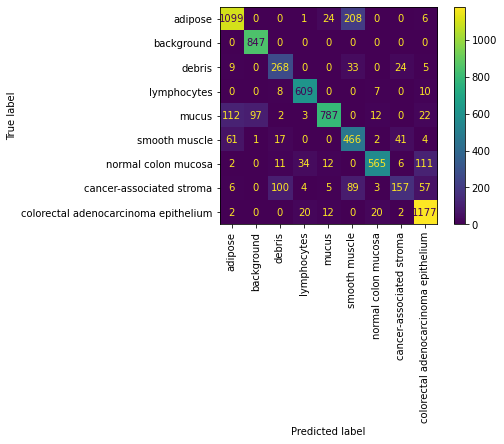

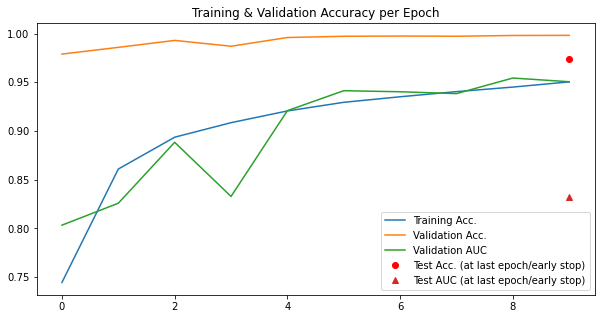

In [22]:
# Runs the classifier again 

clf_condVAE_pathmnist = run_classifier_pipeline("pathmnist", info_flags, condVAE_pathmnist_loader)

### DermaMNIST

#### Training the Conditional VAE

In [5]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["dermamnist"][0]["label"])
n_channels = info_flags["dermamnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = dermamnist[3]
val_loader = dermamnist[5]
test_loader = dermamnist[4]

# Runs the conditional VAE
dermamnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="dermamnist", 
    output_intermediary_info=True,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![dermamnist_condvae](assets/dermamnist_conditionalVAE.png)

#### Generating an upgraded dataset

In [24]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

condVAE_dermamnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/dermamnist/dermamnist_model_epoch37.pth", 
    dermamnist[0], 128, dermamnist[4], dermamnist[5], len(dermamnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "DermaMNIST",
  "description": "The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3\u00d7600\u00d7450 are resized into 3\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/dermamnist.npz?download=1",
  "MD5": "0744692d530f8e62ec473284d019b0c7",
  "task": "multi-class",
  "label": {
    "0": "actinic keratoses and intraepithelial carcinoma",
    "1": "basal cell carcinoma",
    "2": "benign keratosis-like lesions",
    "3": "dermatofibroma",
    "4": "melanoma",
    "5": "melanocytic nevi",
    "6": "vascular lesions"
  },
  "n_channels": 3,
  "n_samples": {
    "train": 7007,
    "val": 1003,
    "test": 2005
  },
  "license": "CC B

100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.25it/s]


train -- accuracy: 0.61
val -- accuracy: 0.86,  AUC: 0.67
Epoch 1



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.58it/s]


train -- accuracy: 0.64
val -- accuracy: 0.87,  AUC: 0.68
Epoch 2



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 67.07it/s]


train -- accuracy: 0.66
val -- accuracy: 0.88,  AUC: 0.69
Epoch 3



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 67.09it/s]


train -- accuracy: 0.67
val -- accuracy: 0.89,  AUC: 0.7
Epoch 4



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.48it/s]


train -- accuracy: 0.69
val -- accuracy: 0.89,  AUC: 0.71
Epoch 5



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.75it/s]


train -- accuracy: 0.7
val -- accuracy: 0.91,  AUC: 0.74
Epoch 6



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 67.10it/s]


train -- accuracy: 0.71
val -- accuracy: 0.9,  AUC: 0.74
Epoch 7



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.70it/s]


train -- accuracy: 0.72
val -- accuracy: 0.91,  AUC: 0.71
Epoch 8



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.75it/s]


train -- accuracy: 0.72
val -- accuracy: 0.91,  AUC: 0.74
Epoch 9



100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.54it/s]


train -- accuracy: 0.74
val -- accuracy: 0.91,  AUC: 0.72
test -- accuracy: 0.91,  AUC: 0.72


<Figure size 720x720 with 0 Axes>

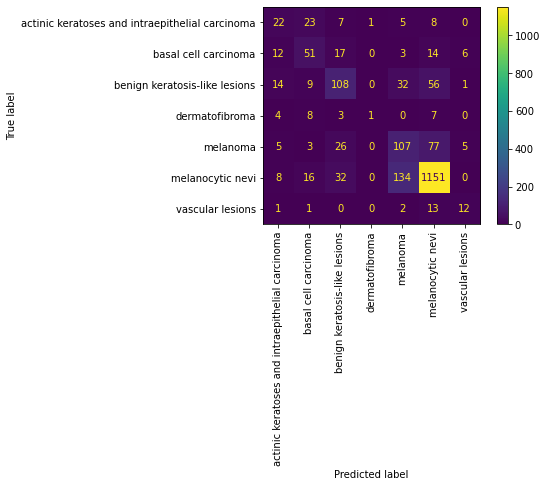

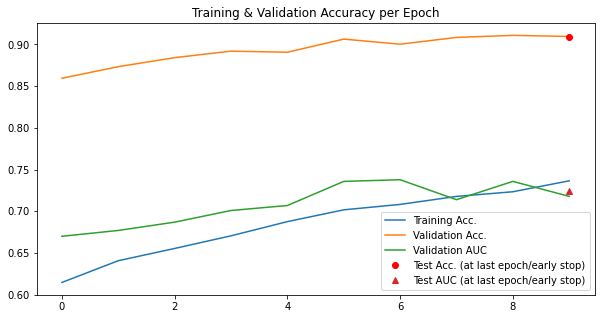

In [25]:
# Runs the classifier again 

clf_condVAE_dermamnist = run_classifier_pipeline("dermamnist", info_flags, condVAE_dermamnist_loader)

### OctMNIST

#### Training the Conditional VAE

In [26]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["octmnist"][0]["label"])
n_channels = info_flags["octmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = octmnist[3]
val_loader = octmnist[5]
test_loader = octmnist[4]

# Runs the conditional VAE
octmnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="octmnist", 
    output_intermediary_info=False,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![octmnist_condvae](assets/octmnist_conditionalVAE.png)

#### Generating an upgraded dataset

In [27]:
# Creates a new data loader with the augmented data added to the already existing data
# 4% generated data was added, with weights corresponding to the rarity of the class 

condVAE_octmnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/octmnist/octmnist_model_epoch31.pth", 
    octmnist[0], 128, octmnist[4], octmnist[5], 4000,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "OCTMNIST",
  "description": "The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384\u22121,536)\u00d7(277\u2212512). We center-crop the images and resize them into 1\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/octmnist.npz?download=1",
  "MD5": "c68d92d5b585d8d81f7112f81e2d0842",
  "task": "multi-class",
  "label": {
    "0": "choroidal neovascularization",
    "1": "diabetic macular edema",
    "2": "drusen",
    "3": "normal"
  },
  "n_channels": 1,
  "n_samples": {
    "train": 97477,
    "val": 10832,
    "test": 1000
  },
  "license": "CC BY 4.0"
}
Epoch 0



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 71.15it/s]


train -- accuracy: 0.8
val -- accuracy: 0.93,  AUC: 0.84
Epoch 1



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 68.78it/s]


train -- accuracy: 0.87
val -- accuracy: 0.95,  AUC: 0.83
Epoch 2



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 66.57it/s]


train -- accuracy: 0.88
val -- accuracy: 0.96,  AUC: 0.88
Epoch 3



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 66.60it/s]


train -- accuracy: 0.9
val -- accuracy: 0.95,  AUC: 0.87
Epoch 4



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 68.43it/s]


train -- accuracy: 0.9
val -- accuracy: 0.97,  AUC: 0.9
Epoch 5



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 66.72it/s]


train -- accuracy: 0.91
val -- accuracy: 0.96,  AUC: 0.88
Epoch 6



100%|█████████████████████████████████████████| 793/793 [00:12<00:00, 65.80it/s]


train -- accuracy: 0.92
val -- accuracy: 0.97,  AUC: 0.91
Epoch 7



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 69.66it/s]


train -- accuracy: 0.92
val -- accuracy: 0.96,  AUC: 0.89
Epoch 8



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 68.89it/s]


train -- accuracy: 0.93
val -- accuracy: 0.97,  AUC: 0.92
Epoch 9



100%|█████████████████████████████████████████| 793/793 [00:11<00:00, 67.61it/s]


train -- accuracy: 0.93
val -- accuracy: 0.96,  AUC: 0.89
test -- accuracy: 0.92,  AUC: 0.67


<Figure size 720x720 with 0 Axes>

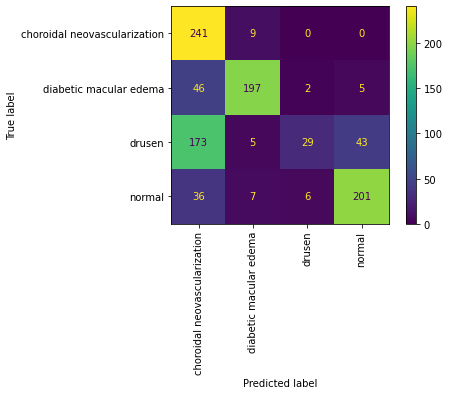

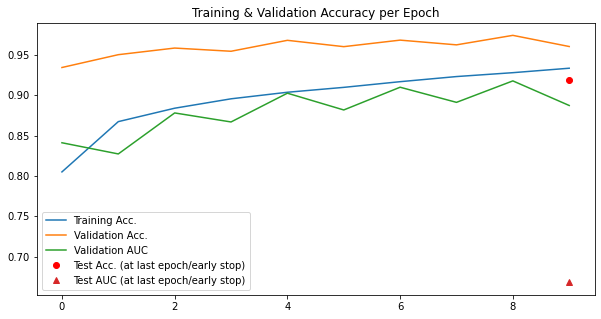

In [28]:
# Runs the classifier again 

clf_condVAE_octmnist = run_classifier_pipeline("octmnist", info_flags, condVAE_octmnist_loader)

### PneumoniaMNIST

#### Training the Conditional VAE

In [29]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["pneumoniamnist"][0]["label"])
n_channels = info_flags["pneumoniamnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 150
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = pneumoniamnist[3]
val_loader = pneumoniamnist[5]
test_loader = pneumoniamnist[4]

# Runs the conditional VAE
pneumoniamnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="pneumoniamnist", 
    output_intermediary_info=False,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![pneumoniamnist_condvae](assets/pneumonia_conditionalVAE.png)

#### Generating an upgraded dataset

In [30]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

condVAE_pneumoniamnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/pneumoniamnist/pneumoniamnist_model_epoch38.pth", 
    pneumoniamnist[0], 128, pneumoniamnist[4], pneumoniamnist[5], len(pneumoniamnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "PneumoniaMNIST",
  "description": "The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384\u22122,916)\u00d7(127\u22122,713). We center-crop the images and resize them into 1\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/pneumoniamnist.npz?download=1",
  "MD5": "28209eda62fecd6e6a2d98b1501bb15f",
  "task": "binary-class",
  "label": {
    "0": "normal",
    "1": "pneumonia"
  },
  "n_channels": 1,
  "n_samples": {
    "train": 4708,
    "val": 524,
    "test": 624
  },
  "license": "CC BY 4.0"
}
Epoch 0



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 75.10it/s]


train -- accuracy: 0.84
val -- accuracy: 0.98,  AUC: 0.74
Epoch 1



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 75.60it/s]


train -- accuracy: 0.95
val -- accuracy: 0.99,  AUC: 0.96
Epoch 2



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 74.19it/s]


train -- accuracy: 0.96
val -- accuracy: 1.0,  AUC: 0.97
Epoch 3



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 74.16it/s]


train -- accuracy: 0.97
val -- accuracy: 0.99,  AUC: 0.96
Epoch 4



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 74.20it/s]


train -- accuracy: 0.98
val -- accuracy: 1.0,  AUC: 0.97
Epoch 5



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 75.33it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.96
Epoch 6



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 75.37it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
Epoch 7



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 75.02it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
Epoch 8



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 74.30it/s]


train -- accuracy: 1.0
val -- accuracy: 1.0,  AUC: 0.97
Epoch 9



100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 74.81it/s]


train -- accuracy: 1.0
val -- accuracy: 1.0,  AUC: 0.97
test -- accuracy: 0.96,  AUC: 0.83


<Figure size 720x720 with 0 Axes>

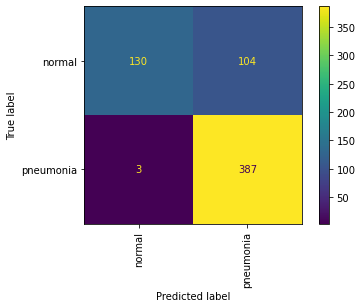

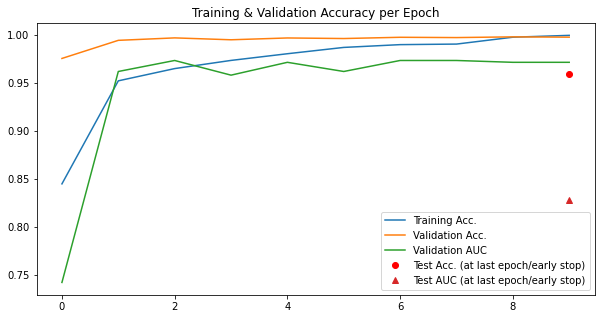

In [31]:
# Runs the classifier again 

clf_condVAE_pneumoniamnist = run_classifier_pipeline("pneumoniamnist", info_flags, condVAE_pneumoniamnist_loader)

### BreastMNIST

#### Training the Conditional VAE

In [86]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["breastmnist"][0]["label"])
n_channels = info_flags["breastmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 150
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = breastmnist[3]
val_loader = breastmnist[5]
test_loader = breastmnist[4]

# Runs the conditional VAE
breastmnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="breastmnist", 
    output_intermediary_info=False,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![breastmnist_condvae](assets/breastmnist_conditionalVAE.png)

#### Generating an upgraded dataset

In [93]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

condVAE_breastmnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/breastmnist/breastmnist_model_epoch36.pth", 
    breastmnist[0], 128, breastmnist[4], breastmnist[5], len(breastmnist[0])//30,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "BreastMNIST",
  "description": "The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1\u00d7500\u00d7500 are resized into 1\u00d728\u00d728.",
  "url": "https://zenodo.org/record/5208230/files/breastmnist.npz?download=1",
  "MD5": "750601b1f35ba3300ea97c75c52ff8f6",
  "task": "binary-class",
  "label": {
    "0": "malignant",
    "1": "normal, benign"
  },
  "n_channels": 1,
  "n_samples": {
    "train": 546,
    "val": 78,
    "test": 156
  },
  "license": "CC BY 4.0"
}
Epoch 0



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 69.76it/s]


train -- accuracy: 0.47
val -- accuracy: 0.76,  AUC: 0.56
Epoch 1



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.80it/s]


train -- accuracy: 0.73
val -- accuracy: 0.71,  AUC: 0.73
Epoch 2



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.06it/s]


train -- accuracy: 0.73
val -- accuracy: 0.69,  AUC: 0.73
Epoch 3



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 70.77it/s]


train -- accuracy: 0.73
val -- accuracy: 0.69,  AUC: 0.73
Epoch 4



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 69.09it/s]


train -- accuracy: 0.73
val -- accuracy: 0.7,  AUC: 0.73
Epoch 5



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 70.65it/s]


train -- accuracy: 0.73
val -- accuracy: 0.73,  AUC: 0.73
Epoch 6



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 70.62it/s]


train -- accuracy: 0.74
val -- accuracy: 0.75,  AUC: 0.73
Epoch 7



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 71.07it/s]


train -- accuracy: 0.76
val -- accuracy: 0.77,  AUC: 0.74
Epoch 8



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 71.83it/s]


train -- accuracy: 0.8
val -- accuracy: 0.79,  AUC: 0.77
Epoch 9



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.07it/s]


train -- accuracy: 0.83
val -- accuracy: 0.82,  AUC: 0.78
test -- accuracy: 0.79,  AUC: 0.78


<Figure size 720x720 with 0 Axes>

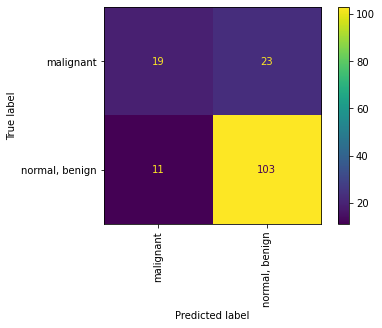

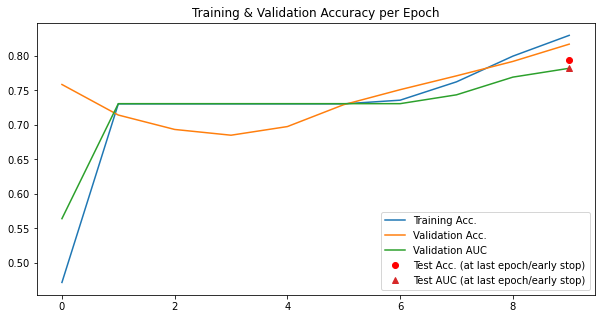

In [94]:
# Runs the classifier again 

clf_condVAE_breastmnist = run_classifier_pipeline("breastmnist", info_flags, condVAE_breastmnist_loader)

### OrganAMNIST

#### Training the Conditional VAE

In [35]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["organamnist"][0]["label"])
n_channels = info_flags["organamnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 150
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = organamnist[3]
val_loader = organamnist[5]
test_loader = organamnist[4]

# Runs the conditional VAE
organamnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="organamnist", 
    output_intermediary_info=False,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![organamnist_condvae](assets/organamnist_conditionalVAE.png)

#### Generating an upgraded dataset

In [36]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

condVAE_organamnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/organamnist/organamnist_model_epoch16.pth", 
    organamnist[0], 128, organamnist[4], organamnist[5], len(organamnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "OrganAMNIST",
  "description": "The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1\u00d728\u00d728 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/organamnist.npz?download=1",
  "MD5": "866b832ed4eeba67bfb9edee1d5544e6",
  "task": "multi-class",
  "label": {
    "0": "bladder",
    "1": "femur-left",

100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 69.04it/s]


train -- accuracy: 0.67
val -- accuracy: 1.0,  AUC: 0.91
Epoch 1



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 70.62it/s]


train -- accuracy: 0.89
val -- accuracy: 1.0,  AUC: 0.94
Epoch 2



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 73.33it/s]


train -- accuracy: 0.93
val -- accuracy: 1.0,  AUC: 0.96
Epoch 3



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 72.45it/s]


train -- accuracy: 0.96
val -- accuracy: 1.0,  AUC: 0.96
Epoch 4



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 73.18it/s]


train -- accuracy: 0.97
val -- accuracy: 1.0,  AUC: 0.96
Epoch 5



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 72.22it/s]


train -- accuracy: 0.97
val -- accuracy: 1.0,  AUC: 0.95
Epoch 6



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 71.58it/s]


train -- accuracy: 0.98
val -- accuracy: 1.0,  AUC: 0.97
Epoch 7



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 71.93it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.96
Epoch 8



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 71.72it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
Epoch 9



100%|█████████████████████████████████████████| 298/298 [00:04<00:00, 69.50it/s]


train -- accuracy: 0.99
val -- accuracy: 1.0,  AUC: 0.97
test -- accuracy: 0.99,  AUC: 0.87


<Figure size 720x720 with 0 Axes>

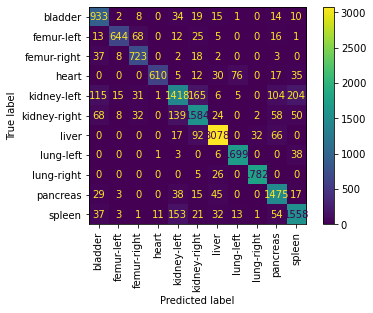

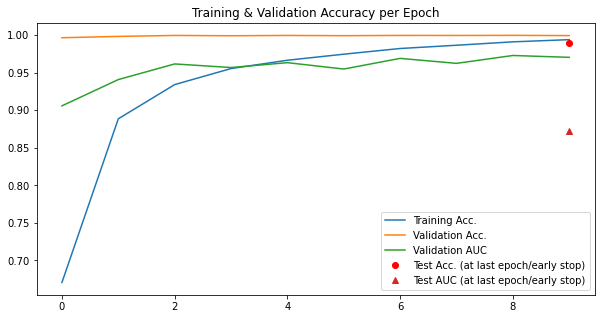

In [37]:
# Runs the classifier again 

clf_condVAE_organamnist = run_classifier_pipeline("organamnist", info_flags, condVAE_organamnist_loader)

### OrganCMNIST

#### Training the Conditional VAE

In [38]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["organcmnist"][0]["label"])
n_channels = info_flags["organcmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 150
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = organcmnist[3]
val_loader = organcmnist[5]
test_loader = organcmnist[4]

# Runs the conditional VAE
organcmnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="organcmnist", 
    output_intermediary_info=False,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![organcmnist_condvae](assets/organcmnist_conditionalVAE.png)

#### Generating an upgraded dataset

In [39]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

condVAE_organcmnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/organcmnist/organcmnist_model_epoch30.pth", 
    organcmnist[0], 128, organcmnist[4], organcmnist[5], len(organcmnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "OrganCMNIST",
  "description": "The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1\u00d728\u00d728 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/organcmnist.npz?download=1",
  "MD5": "0afa5834fb105f7705a7d93372119a21",
  "task": "multi-class",
  "label": {
    "0": "bladder",
    "1": "femur-le

100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 72.35it/s]


train -- accuracy: 0.47
val -- accuracy: 0.98,  AUC: 0.79
Epoch 1



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 69.77it/s]


train -- accuracy: 0.77
val -- accuracy: 0.99,  AUC: 0.88
Epoch 2



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 71.74it/s]


train -- accuracy: 0.85
val -- accuracy: 1.0,  AUC: 0.93
Epoch 3



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 73.54it/s]


train -- accuracy: 0.88
val -- accuracy: 1.0,  AUC: 0.93
Epoch 4



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 73.69it/s]


train -- accuracy: 0.9
val -- accuracy: 1.0,  AUC: 0.94
Epoch 5



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 73.84it/s]


train -- accuracy: 0.92
val -- accuracy: 1.0,  AUC: 0.94
Epoch 6



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 71.64it/s]


train -- accuracy: 0.93
val -- accuracy: 1.0,  AUC: 0.95
Epoch 7



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 72.96it/s]


train -- accuracy: 0.95
val -- accuracy: 1.0,  AUC: 0.93
Epoch 8



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 73.37it/s]


train -- accuracy: 0.95
val -- accuracy: 1.0,  AUC: 0.95
Epoch 9



100%|█████████████████████████████████████████| 112/112 [00:01<00:00, 73.66it/s]


train -- accuracy: 0.97
val -- accuracy: 1.0,  AUC: 0.96
test -- accuracy: 0.99,  AUC: 0.86


<Figure size 720x720 with 0 Axes>

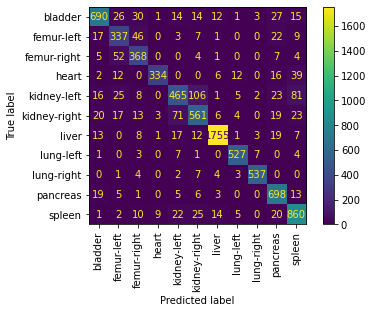

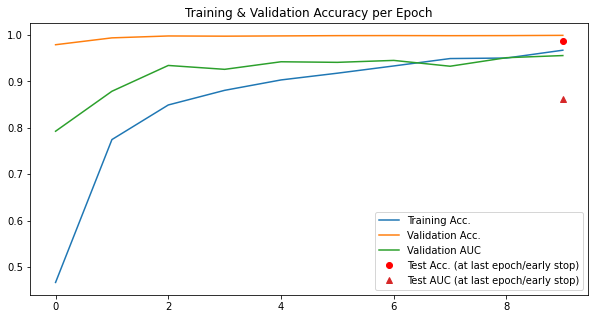

In [40]:
# Runs the classifier again 

clf_condVAE_organcmnist = run_classifier_pipeline("organcmnist", info_flags, condVAE_organcmnist_loader)

### OrganSMNIST

#### Training the Conditional VAE

In [41]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["organsmnist"][0]["label"])
n_channels = info_flags["organsmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 150
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = organsmnist[3]
val_loader = organsmnist[5]
test_loader = organsmnist[4]

# Runs the conditional VAE
organsmnist_condVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, 
    n_classes=n_classes, 
    epochs=epochs, 
    name_dataset="organsmnist", 
    output_intermediary_info=False,
    model_type="CondVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![organsmnist_condvae](assets/organsmnist_conditionalVAE.png)

#### Generating an upgraded dataset

In [42]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

condVAE_organsmnist_loader = generate_augmented_dataset_condVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/CondVAE/organsmnist/organsmnist_model_epoch26.pth", 
    organsmnist[0], 128, organsmnist[4], organsmnist[5], len(organsmnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

{
  "python_class": "OrganSMNIST",
  "description": "The OrganSMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Sagittal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in sagittal views (planes). The images are resized into 1\u00d728\u00d728 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.",
  "url": "https://zenodo.org/record/5208230/files/organsmnist.npz?download=1",
  "MD5": "e5c39f1af030238290b9557d9503af9d",
  "task": "multi-class",
  "label": {
    "0": "bladder",
    "1": "femur-

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 72.63it/s]


train -- accuracy: 0.43
val -- accuracy: 0.96,  AUC: 0.64
Epoch 1



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 71.51it/s]


train -- accuracy: 0.66
val -- accuracy: 0.98,  AUC: 0.7
Epoch 2



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 68.31it/s]


train -- accuracy: 0.73
val -- accuracy: 0.99,  AUC: 0.78
Epoch 3



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 69.26it/s]


train -- accuracy: 0.77
val -- accuracy: 0.99,  AUC: 0.82
Epoch 4



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 69.24it/s]


train -- accuracy: 0.8
val -- accuracy: 0.99,  AUC: 0.84
Epoch 5



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 69.00it/s]


train -- accuracy: 0.83
val -- accuracy: 0.99,  AUC: 0.85
Epoch 6



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 69.20it/s]


train -- accuracy: 0.85
val -- accuracy: 0.99,  AUC: 0.85
Epoch 7



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 69.49it/s]


train -- accuracy: 0.87
val -- accuracy: 0.99,  AUC: 0.85
Epoch 8



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 73.33it/s]


train -- accuracy: 0.89
val -- accuracy: 0.99,  AUC: 0.85
Epoch 9



100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 72.67it/s]


train -- accuracy: 0.91
val -- accuracy: 0.99,  AUC: 0.84
test -- accuracy: 0.96,  AUC: 0.7


<Figure size 720x720 with 0 Axes>

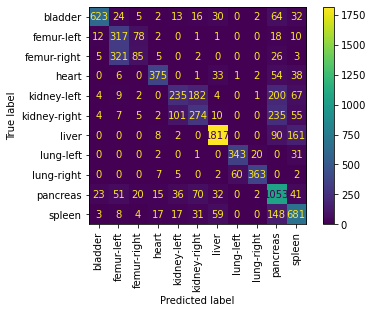

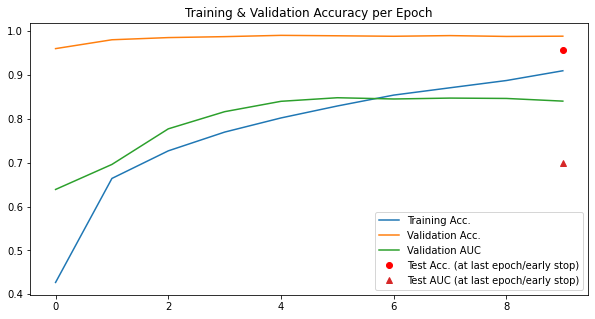

In [43]:
# Runs the classifier again 

clf_condVAE_organsmnist = run_classifier_pipeline("organsmnist", info_flags, condVAE_organsmnist_loader)

## 5. Training a Joint Variational Autoencoder for Data Augmentation and Retraining the Classifier with an Augmented Dataset

### PathMNIST

#### Training the Joint VAE

In [5]:
# Retrieves the dataset parameters
n_channels = info_flags["pathmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
categorical_dims = 50
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = pathmnist[3]
val_loader = pathmnist[5]
test_loader = pathmnist[4]

# Runs the Joint VAE
pathmnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims,
    epochs=epochs, 
    name_dataset="pathmnist", 
    output_intermediary_info=False,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![pathmnist_jointae](assets/pathmnist_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 5% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_pathmnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, latent_dims, categorical_dims,
    "trained_models/JointVAE/pathmnist/.pth", 
    pathmnist[0], 64, pathmnist[4], pathmnist[5], len(pathmnist[0])//20,
    weighted_sampling=True
)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_pathmnist = run_classifier_pipeline("pathmnist", info_flags, jointVAE_pathmnist_loader)

### DermaMNIST

#### Training the Joint VAE

In [17]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["dermamnist"][0]["label"])
n_channels = info_flags["dermamnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
categorical_dims = 50
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = dermamnist[3]
val_loader = dermamnist[5]
test_loader = dermamnist[4]

# Runs the Joint VAE
dermamnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims,
    epochs=epochs, 
    name_dataset="dermamnist", 
    output_intermediary_info=True,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![dermamnist_jointvae](assets/dermamnist_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_dermamnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/JointVAE/dermamnist/.pth", 
    dermamnist[0], 128, dermamnist[4], dermamnist[5], len(dermamnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_dermamnist = run_classifier_pipeline("dermamnist", info_flags, jointVAE_dermamnist_loader)

### OctMNIST

#### Training the Joint VAE

In [21]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["octmnist"][0]["label"])
n_channels = info_flags["octmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 75
categorical_dims = 25
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = octmnist[3]
val_loader = octmnist[5]
test_loader = octmnist[4]

# Runs the Joint VAE
octmnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims,
    epochs=epochs, 
    name_dataset="octmnist", 
    output_intermediary_info=False,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![octmnist_jointvae](assets/octmnist_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 4% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_octmnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/JointVAE/octmnist/.pth", 
    octmnist[0], 128, octmnist[4], octmnist[5], 4000,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_octmnist = run_classifier_pipeline("octmnist", info_flags, jointVAE_octmnist_loader)

### PneumoniaMNIST

#### Training the Joint VAE

In [23]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["pneumoniamnist"][0]["label"])
n_channels = info_flags["pneumoniamnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
categorical_dims = 50
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = pneumoniamnist[3]
val_loader = pneumoniamnist[5]
test_loader = pneumoniamnist[4]

# Runs the Joint VAE
pneumoniamnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims,
    epochs=epochs, 
    name_dataset="pneumoniamnist", 
    output_intermediary_info=False,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![pneumoniamnist_jointvae](assets/pneumonia_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_pneumoniamnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/JointVAE/pneumoniamnist/.pth", 
    pneumoniamnist[0], 128, pneumoniamnist[4], pneumoniamnist[5], len(pneumoniamnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_pneumoniamnist = run_classifier_pipeline("pneumoniamnist", info_flags, jointVAE_pneumoniamnist_loader)

### BreastMNIST

#### Training the Joint VAE

In [25]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["breastmnist"][0]["label"])
n_channels = info_flags["breastmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
categorical_dims = 50
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = breastmnist[3]
val_loader = breastmnist[5]
test_loader = breastmnist[4]

# Runs the Joint VAE
breastmnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims,
    epochs=epochs, 
    name_dataset="breastmnist", 
    output_intermediary_info=False,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![breastmnist_jointvae](assets/breastmnist_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_breastmnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/JointVAE/breastmnist/.pth", 
    breastmnist[0], 128, breastmnist[4], breastmnist[5], len(breastmnist[0])//30,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_breastmnist = run_classifier_pipeline("breastmnist", info_flags, jointVAE_breastmnist_loader)

### OrganAMNIST

#### Training the Joint VAE

In [27]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["organamnist"][0]["label"])
n_channels = info_flags["organamnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
categorical_dims = 50
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = organamnist[3]
val_loader = organamnist[5]
test_loader = organamnist[4]

# Runs the Joint VAE
organamnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims,
    epochs=epochs, 
    name_dataset="organamnist", 
    output_intermediary_info=False,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![organamnist_jointvae](assets/organamnist_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_organamnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/JointVAE/organamnist/.pth", 
    organamnist[0], 128, organamnist[4], organamnist[5], len(organamnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_organamnist = run_classifier_pipeline("organamnist", info_flags, jointVAE_organamnist_loader)

### OrganCMNIST

#### Training the Joint VAE

In [29]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["organcmnist"][0]["label"])
n_channels = info_flags["organcmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
categorical_dims = 50
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = organcmnist[3]
val_loader = organcmnist[5]
test_loader = organcmnist[4]

# Runs the Joint VAE
organcmnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims, 
    epochs=epochs, 
    name_dataset="organcmnist", 
    output_intermediary_info=False,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![organcmnist_jointvae](assets/organcmnist_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_organcmnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/JointVAE/organcmnist/.pth", 
    organcmnist[0], 128, organcmnist[4], organcmnist[5], len(organcmnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_organcmnist = run_classifier_pipeline("organcmnist", info_flags, jointVAE_organcmnist_loader)

### OrganSMNIST

#### Training the Joint VAE

In [31]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["organsmnist"][0]["label"])
n_channels = info_flags["organsmnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
latent_dims = 100
categorical_dims = 50
epochs = 200

In [ ]:
# Retrieves the data loader
train_loader = organsmnist[3]
val_loader = organsmnist[5]
test_loader = organsmnist[4]

# Runs the Joint VAE
organsmnist_jointVAE_model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, latent_dims, categorical_dims=categorical_dims,
    epochs=epochs, 
    name_dataset="organsmnist", 
    output_intermediary_info=False,
    model_type="JointVAE"
)

<u>Output (to avoid rerunning the cell):</u>

![organsmnist_jointvae](assets/organsmnist_jointVAE.png)

#### Generating an upgraded dataset

In [ ]:
# Creates a new data loader with the augmented data added to the already existing data
# 10% generated data was added, with weights corresponding to the rarity of the class 

jointVAE_organsmnist_loader = generate_augmented_dataset_jointVAE(
    n_channels, n_classes, latent_dims,
    "trained_models/JointVAE/organsmnist/.pth", 
    organsmnist[0], 128, organsmnist[4], organsmnist[5], len(organsmnist[0])//10,
    weighted_sampling=True)

#### Retraining the classifier and assessing changes in performance

In [ ]:
# Runs the classifier again 

clf_jointVAE_organsmnist = run_classifier_pipeline("organsmnist", info_flags, jointVAE_organsmnist_loader)